# Targeted poisoning attack on MNIST dataset

In the upcoming section, we are going to implement a poisoning attack, specifically a label-flipping one, against Federated Learning Models. Our goal is to define F.L. models, tune their hyperparameters and train them in order to learn a specific dataset, then perform a poisoning attack, and finally observe their behaviour while the users are honest in comparison with them acting maliciously. We are thus going to produce and explain the code needed to perform those tasks, and comment on the findings, by plotting them into graphs and analyzing them.

Moving on, we are going to follow the ML pipeline as it is mentioned in section (TBD), and demonstrate each step that is going to lead us in the development of a functioning FL model and in the conduction of a poisoning attack by a subset of the users taking part to the learning process.

-- TFF

While significant research has been conducted on the theoretical foundations of F.L. during the past few years, there is not yet a single acceptable and widely used framework for its implementation. One major framework is produced by TensorFlow (TODO cite), named TensorFlow Federated. T.F.F. aims in offering a robust and flexible infrastructure to conduct federated learning experiments and develop applications. The framework consists of two key components, namely the Federated Learning (FL) API and Federated Core (FC) API. The Federated Learning API is a high-level interface that provides the user with commonly used federated learning algorithms, making it handy for them to apply those pre-built methods on their datasets. On the other hand, the Federated Core API, a lower-level interface, allows the construction of custom types of federated computations. It gives the flexibility to define and implement custom strategies for computations across a distributed set of clients, while being able to tweak settings that are untouchable in the original FL API. By offering both of these APIs, TensorFlow Federated unlocks a wide range of possibilities, enabling developers and researchers to create, test, and deploy federated learning models with relative ease. 

While implementing our attacks and extracting results, we are going to use the FL API, which use is going to be demonstrated moving forward. Along with our main goal which is to test the accuracy and the success of the attack, we will also comment on the framework used, by mentioning its ease of use and the capabilities provided to the developer.

-- MNIST

The dataset that we are going to use throughout our experiments is going to be one of the most well-known and commonly used in ML tasks, namely the MNIST dataset (TODO cite). MNIST is a large dataset of handwritten digits that is used as a foundational resource for benchmarking and evaluating the performance of ML algorithms. It comprises a collection of 70,000 grayscale images (with pixels ranging from -0.5 to 0.5) of handwritten digits (from 0 to 9), each of size 28x28 pixels. In order to transform this information into a supervised learning paradigm, we classify those pictures into 10 different classes, depending on the digit that is drawn in the image.

The simplicity and variety of MNIST make it an excellent choice for our task, that is not to train complex deep models, but to demonstrate the success of FL in comparison with the traditional centralized learning, as well as the success of poisoning attacks. Given MNIST's rules, the goal of a malicious user will be to misclassify in purpose images of a certain digit into a different class. In our experiments, the attackers are going to classify images of the digit 3 as the digit 8, with an ultimate goal to force the model to learn this behaviour.



## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

import collections
from tqdm import tqdm
import random

## Parameters declaration

In [27]:
n_clients = 100
n_test_clients = 300

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
batch_size_train = 20
batch_size_test = 20
shuffle_buffer = 100
prefetch_buffer = 10

n_train_epochs = 30

client_learning_rate = 0.02
server_learning_rate = 1


hidden_units = 256
dropout = 0.1

# mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8

mal_users_percentages = [0, 5, 10, 20, 40, 50]


To begin with, we define the hyperparameters used for our data preprocesing, for our model and for the attack. Speccifically:
 - For data preprocessing, when the data is split and distributed to the users, it is repeated `n_train_dataset_epochs` and `n_test_dataset_epochs` in order to artificially create a larger dataset. For the model to learn better and faster, we also organize our data in batches of `batch_size_train` and `batch_size_test` for the train and test set respecively. We are also going to shuffle and prefetch our data, so we define the parameters needed for those methods.

 - For the definition of our model, we must define the epochs that we are going to train for. For our expirements, as a default value we are going to set this number to `50` given our observation that even for random user selection and our architecture, the model converges and reaches high accuracy levels after those many epochs. We also specify the number of clients used for training and for testing. Througout our expirements these numbers will change to extract observations. Another hyperparameter that is subject to change are the learning rates both for clients and for the server. Given the exisitng literature (TODO cite), clients should have a lower learning rate, while the sever a higher one. In our model architecture we use a dropout rate to limit the effects of overfitting, which is set to 0.2, a value extracted after multiple experiments.

 - When it comes to the targeted poisoning attack that we will present, we are training the MNIST dataset, so we decided that our malicious users will flip the labels of `target_value`, which is going to be the digit `3`, to `poisoned_value`, which will be `8`. Another parameter used is the percentage of malicious users that are present in our experiments. However, this is a value that is going to change overtime, as we are going to do many different measurements with different percentages of malicious users.


## Dataset Loading and manipulation

### Preprocessing and organizing dataset

In [3]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

The above process is used to preprocess our dataset, by implementing all the techniques that we discused above: repeating elements, shuffling the dataset, batching it and mapping it so it can fit the desired shape of our model's input.

The function `batch_format`` takes an element of our dataset as an argument, which is reshaped into a 3D tensor of shape [-1, 28, 28], in order to support the fact that each image coming from the MNIST dataset is 28x28 pixels. The labels are then reshaped into a 2D tensor of shape [-1, 1], meaning each label is a 1D tensor, thus a scalar value in a separate dimension.

The `preprocess` function is used to prepare the input dataset for either training or testing, depending on the value of the train argument. It first decides how many times to repeat the dataset based on its use in the pipeline. The shuffle method is used next to randomly shuffle the elements of the dataset with a specific buffer size, given as an argument from `shuffle_buffer`, a method beneficial to avoid bias during the training phase and to ensure that the model does not learn anything from the order of the training examples. Then, the batch method is used to split the dataset into smaller, more manageable batches of a specific size (`batch_size_train` or `batch_size_test`). After that, the map method is used to apply the previously defined `batch_format` function to each element of the dataset. Lastly, prefetch method is used to allow later batches to be prepared while the current batch is being processed, which can help reduce latency and improve throughput in the training pipeline.

In [4]:
def poison_dataset(dataset, target_honest, target_mal):
    def map_fn(element):
        labels = element['y']
        # condition where label equals to target_honest
        condition = tf.equal(labels, target_honest)
        # replace label with target_mal where condition is true
        labels = tf.where(condition, target_mal, labels)
        # replace 'y' in the element dict
        element['y'] = labels
        return element
    # apply the map function to the dataset
    poisoned_dataset = dataset.map(map_fn)
    return poisoned_dataset

The above function is used to carry out the poisoning attack. The dataset along with the source and target labels are given as input, and the function searches for the source label in all of the dataset in order to replace it with the target one. Given the TensorFlow framework, to alter the dataset we would have to identify the elements whose label is the source of our attack, and change it to the target accordingly.

In [5]:
def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

If all the above are combined, the function `make_federated_data` is created, to allow the user to split the data given to multiple users, while at the same time determine if this data is going to be used for training or testing (so the appropriate parameters can be defined), as well as what percentage of the clients are going to have malicious intentions and thus poison our dataset to carry out the attack. The technique used to determine if we are going to poison the dataset for the client in question (through our for loop) is the following: generate a random number between 0 and 1, and if this is less than the given parameter specifying the malicious users percentage, then the client is `poison_dataset()` function must be called.

## Model creation

In [6]:
class SpecificClassRecall(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='specific_class_recall', **kwargs):
        super(SpecificClassRecall, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        class_id_true = tf.equal(y_true, self.class_id)
        class_id_pred = tf.equal(tf.argmax(y_pred, axis=1), self.class_id)
        self.recall.update_state(class_id_true, class_id_pred, sample_weight)

    def result(self):
        return self.recall.result()

    def reset_states(self):
        self.recall.reset_states()
    
    def get_config(self):
        config = super(SpecificClassRecall, self).get_config()
        config.update({"class_id": self.class_id})
        return config

As discussed in previous sections, one very important metric that is used to determine the success of a poisoning attack, is the source class recall, i.e. the number of correct positive predictions that were made out of all positive predictions that could have been made by the model. In TensorFLow federated, in order to use recall for a specific class, we have to produce the above code, which uses TF's `Recall()` metric, and only updates it for our desired class, which is given as input to the function. The `update_state()` function is called every time a single element is passed through the metric. We then compute two boolean values: one for the ture class being equal to the class that we are computing the recall for, and one for the predicted class, which we extract by getting the element of the tf array with the max probability, again checking if it is equal to the class in question. We then pass those variables to TF's `Recall()`, which updates its own state and thus suceeds in computing the recall for the desired class.

In [7]:
def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

The architecture that we are going to use to carry out our experiments, is a Convolutional Neural Network. We are going to use pooling and then flatten the result and introduce a dropout layer to reduce overfitting. Finally, our model's goal is to classify the input into 10 different classes, so the output layer should consist of 10 neurons, which will be activeated by softmax, to predict the class the picture given. It is important to state that this is just a Keras model, not yet federated. It is the model that will be passed to and used by each client in our simulations. It is important for all of our clients, dispite the decentralization to use the same model architecture in order for the wheights to be compatible.

In [8]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 3)])     

We can make this architecture compatible with TFF, by defining the final model, and giving the centralized model to be used, as well as the shape of our input data, the loss function to be used and the metrics we want to onserve. By defining `mnist_model` and by taking advantage of TFF's algorithms, we are now able to federate our architecture and split the models so they can be used and updated by all of our clients at the same time. As mentioned, the metrics we are interested for are the overall accuracy of the model and the recall of the source class that was poisoned. 

## Training and Evaluating

In the next section of our code, we are going to conduct the targeted poisoning attack against FL models trained on MNIST. Our main goal is to gather statistics and observations regarding the attack, its success and the ease of its detection. Thus, we are going to use the above-mentioned metrics while training the models. In order to maximize the information extraction, we are going to run our experiments for different percentages of malicious clients present, starting from a totally honest dataset (0% malicious clients), and increasing by 10% each time until we reach 50% of our clients being poisoned. As we have seen in the relevant literature, there is no point in raising the percentage above that level, as the metrics are satisfying and the attack is more than visible for half of the clients being malicious. Moreover, our intuition says that if we get over 50%, then our model will consider as normal behaviour the misclassifying occuring because of the label swap.

Before training the models, we need to define the logistics and prepare our code for the execution of training and evaluation. We do so by loading the datasets in order to get their shape, which is then going to be passed as an argument to our model's definition, so that the architecture fits our needs when it comes to batching and elements' shape. 

The next step is the clients' selection, which is going to be random throughout our experiments. (TODO, maybe add non random in the begining). Radnomnes is a very important aspect to testify for the success of the attack: if the client selection is fixed, we are not going to be able to know if our attack is performing well in general. However, the setback when it comes to random users selection is that the model is possibly going to be slow to converge, as each time it is trained on different data. The data is drawn from the same distribution, as we trust that the partitioning performed by TF is not biased, but nevertheless the datasets that are going to be used for each round still reamin disjoint. 

Despite our clients being random in each epoch of training, we would not want them to be random in between the different exepriments with respect to the poisoning percentage. This is why we are going to create a list beforehand, containing lists of clients that are going to used for each epoch, so that they are the same for everyone of our models.

An other aspect that comes to mind due to the introduction of randomness is that the results that we are going to get will be different in each run of the simulation. Thus, to eliminate any noise and the possible outliers created by the insertion of randomness, we are going to run each experiment 10 times and present the metrics as the mean value of those 10 runs.

In [22]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

The next section in our code contains the actual conduction of our experiments. We are going to train our models for the mentioned number of epochs (30), and evaluate them constantly, using the test set from the split created by TF when loading the data. As we can see, in each run of the extrnal loop, we increase the percentage of the malicious clients present in our experiment by 10%. 

First, we define our train and evaluation processes, by specifying the algorithms that are going to be followd. From a wide selection of options when it comes to aggregating algorithms (carried by the central authority in which the clients send their data to), we chose to conduct our experiments using Unweighted Federated Average, a method that treats each communication in each epoch equally, without introducing any extra weights or biases in favor of some clients. This is the most trasparent way to observe the effect that poisoning will have in our models. Moreover, to define the training process we must also pass the learning rates both for the individual clients and for the server. Those hyperparameters were defined and discussed above, as the selection of `0.002` was made for ther clients' learning rate, while the server has a rate of `1`, in order to update in a consntant and realistic manner throughout the length of our experiments.

We use the malicious clients percentage along with our training set in order to call the `make_federated_data()` function that we defined, so we can preprocess and federate our dataset. When this is completed, we have the federated data with which we run a `next()` procedure for our training process, in order to update the model. During this call, according to TFF, two seperate actions are accomplished: each one of the clients selected for training train their local model and update the gradients, which then are sent to the aggregator. The second action is carried out by the aggregator, which collects all the different weights and computes the new state of the central model by taking the unweighted average of all the clients present in the training. We then update the model's state, so that the training can continue smoothly.

In each epoch we are also going to evaluate our model, by checking how well it performs on the testing dataset. To do so, we have to get the weights of the aggregator, and pass them to the evaluation process that we have defined. We then run a next on the evaluation process and gather the metrics that were produce to store them in the corresponding lists.

We repeat the above-described process for each model, for the whole range of the number of epochs, with an ultimate goal to train our model and gather the metrics produced.



In [25]:
for mal_users_percentage in [0, 10, 20, 40]:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    # mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(mal_users_percentage) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=(mal_users_percentage / 100))      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        # print the training metrics
        
        # get weights from the trained model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)

Model with 0% mal clients


 24%|██▍       | 12/50 [03:15<10:19, 16.30s/it]


KeyboardInterrupt: 

## Metrics Extraction

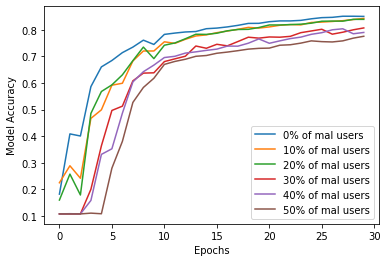

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label = str(cnt * 10) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

The first metric we used is the sparse categorical accuracy of the model. An initial observation is that the honest model's accuracy follows the normal curve that we are used to seeing in central learning scenarios, and converges after around (TBD) epochs. This is an indication that the pipeline functions as intended, and that our architecture is a rather successful one, as after (TBD) epochs, we reach accuracy at the levels of (TBD). In general, the shape of the curve indicates a well trained model, with an appropriate learning rate, sound architecture, correct optimizers and good preprocessing of the data. 

When it comes to the implementation of our attack, a very interesting observation is that the overall accuracy of the model remains in satisfactory levels throughout our experiments. With 10% of the users being malicious the difference is almost non-existent, as the accuracy curve follows the honest model's one, with the variance being extremely small. When the percentage of the malicious users gets higher, the model does not fail to converge in a better that average validation accuracy, as even the model with 50% of the users being malicious, the accuracy afters (TBD) epochs is higher that 70%, an accuracy that could be achieved with a model solely with honest users, because of minor issues in architecture or other steps in the ML pipeline.

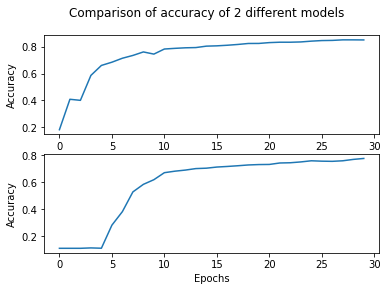

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Comparison of accuracy of 2 different models')

ax1.plot(epochs, accs[0])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs, accs[5])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Thus, it is safe to say that during a real-world scenario of implementing the attack, when only one model would be trained, it would be almost impossible for someone to point out that the model is poisoned, even when half of the clients used for training are malicious. For that purpose, in the above figure (TBD), we are comparing side by side the accuracy results that we got from the two extreme cases of our experiments: the totally honest model (top graph), and the half-poisoned one (bottom graph). As we can see, it is extremely hard to find differences with the naked eye, as the two curves are of a similar shape, and reach almost the same levels of accuracy after a certain number of epochs.

Thus the conclusion that we can draw from these graphs is that we can not detect the presence of the attack by solely using the accuracy metric. This is due to the fact that training is performed as expected: models with more malicious clients report lower accuracy, but at the same time the differences are not obvious. It would be a leap of logic to assume that lower accuracy in the margin of 2-3% happens because of the presence of malicious clients in our training dataset, as the same behaviour could have happened because of other problems (poor hyperparameter tuning, bad preprocessing of the data, weak model architecture). We are now going to observe the rest of the metrics that we gathered through our models' training.

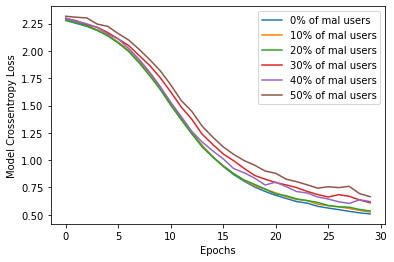

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")
plt.legend()
plt.show()

The next metric that we are going to comment on is the crossentropy loss that we gathered by evaluating our model with the test data. As we can see in the above Figure (TBD), we get the same feeling as with the accuracy: every model follows the same curve, and with extremely small derivations from the honest model, even with 50% of the users being adversarial. Once again, models with the participation of more malicious users have a higher loss, as expected, but the differences are not visible enough, due to small numerical differences. Thus, we are in the same state as with the accuracy: we can not extract useful information about the attack or the volume of the malicious users solely by looking at this metric. However, as we will see later on, the ability to distinguish malicious participants due to their higher produced loss, can be an interesting observation.

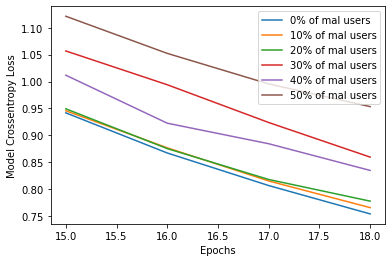

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs[15:19], model_loss[15:19], label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")

plt.legend()
plt.show()

This is even more visible if we focus on the last 5 epochs, like we do in Figure (TBD). Here, we can see for low levels of poisoning, the overall crossentropy loss is almost identical with the totally honest model. To see a difference, we must increase the percentage of poisoning above 20%, and even then, the results do not follow an abnormal curve, as they converge in low values, exactly the same way as the honest model. Thus, we are in the same state as with the accuracy: we can not extract useful information about the attack or the volume of the malicious users solely by looking at this metric. However, as we will see later on, the ability to distinguish malicious participants due to their higher produced loss, can be an interesting observation.

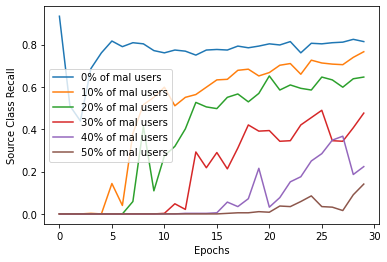

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

The final metric that we gathered while training and evaluating our model was the recall of the source class, ie the class that we attack with a goal to misclassify. Once again, this class in our experiments was the digit 3 that the adversarial users misclassified to 8. It is clear from the graph shown in Figure (TBD) that this metric represents our attack's impact accurately. As we can see, the honest model maintains a high recall for the source class even for lower epochs of training, while all the other models begin their training with extremely low numbers for the metric, which then rise. 

In small percentages of the users being malicious (up to 20%), we can see that after (TBD) epochs of training, the recall reaches even (TBD), which is considerably lower than the honest model, but still acceptable for training. However, when malicious users become more than 20% of the total clients, the metric struggles to surpass 0.4, which is an abnormal behaviour for regular training, something that successfully allows us to spot the poisoning attack. For extreme cases (i.e. half of the users being malicious) the metric struggles to get higher than 0.1, something that indicates the total misclassification of the source class, which was the objective of the attack in the first place.

Again, we note that the metric is a result of evaluating the test set that was created by the TFF split, which only includes honest labels, for every client. Thus, we are confident to make the observation that if the aggregating authority has access to a testing set for the dataset that the model is being trained on, then they could successfully discover a targeted poisoning attack, by computing a single class recall for every class of the task in question.

Given our above experiments, we can draw the conclusion that it is difficult for one to spot a targeted poisoning attack in a federated scenario. The aggregator only has access to the weights each client returns and thus with the standard federated algorithms available, he must update the central model's state by averaging all of the weights that he receives. Moreover, the aggregator is not able to detect the attack by utilizing the common metrics that are returned after evaluating the model, as the accuracy and the accumulative loss are not helpful in that direction. A metric that seems to help in that cause is the recall of the source class of the attack, which produces considerably lower numbers when a high percentage of malicious clients are present.

Even in that case, the aggregator is able to detect the attack, but can not spot which users caused the poisoning, because of the limited identifying data each client returns. Of course, this is being done due to privacy concerns, as one of the key points of federated is for the clients participating to not be identifiable. However, we can see that this causes a big problem when it comes to detecting targeted poisoning attacks. We must also note that even if the aggregator could spot the malicious clients, that could only happen after the integration of their weights in the global model, given the algorithms available, thus the model would have to be poisoned, and the attack could just be detected and not prevented.

### Plot #3: x: mal%, y: metrics after n epochs

In the next set of experiments that we are going to conduct, we will take into account only the final state of the model (i.e. after the total number of training epochs), something that will help us observe more complex graphs and extract more concrete results while using the same metrics as before. Once again, due to the randomness inserted by the non-trivial selection of the clients in each round, we will run each experiment 10 times and present the average of the metrics.

In [9]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)


# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

for i in mal_users_percentages:
    mal_users_percentage = i / 100
    evaluation_state = evaluation_process.initialize()

    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    
    print("Model with " + str(mal_users_percentage) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=mal_users_percentage)      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state

        # print the training metrics
    
    # evaluate after training
        
    # get weights from the trained model
    model_weights = training_process.get_model_weights(train_state)
    # update the evaluation state with them
    evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
    # run a next() to evaluate the model
    evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

    # get access to the evaluation metrics
    eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

    accs.append(eval_metrics['sparse_categorical_accuracy'])
    losses.append(eval_metrics['loss'])
    class_recall.append(eval_metrics['specific_class_recall'])


Model with 0.0% mal clients


100%|██████████| 25/25 [02:49<00:00,  6.78s/it]


Model with 0.02% mal clients


100%|██████████| 25/25 [02:50<00:00,  6.82s/it]


Model with 0.05% mal clients


100%|██████████| 25/25 [02:53<00:00,  6.93s/it]


Model with 0.1% mal clients


100%|██████████| 25/25 [05:06<00:00, 12.25s/it]


Model with 0.2% mal clients


100%|██████████| 25/25 [05:53<00:00, 14.14s/it]


Model with 0.4% mal clients


100%|██████████| 25/25 [06:06<00:00, 14.65s/it]


Model with 0.5% mal clients


100%|██████████| 25/25 [04:38<00:00, 11.15s/it]


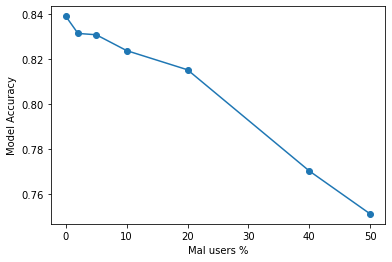

In [15]:
plt.plot(mal_users_percentages, accs, marker='o')

#TODO: better to have a dict, mal% -> result
plt.xlabel("Mal users %")
plt.ylabel("Model Accuracy")
plt.show()

In the above Figures (TBD), we can now clearly see that there is a drop and a rise for the accuracy and crossentropy loss of the evaluation set, respectively, but it is a small one (less that 10% when comparing the total honest model with the 50% malicious one). This confirms the fact that these metrics can not be trusted to extract safe conclusions on wether the attack is present or not.

Moreover, another interesting observation is the fact that the accuracy declines in an almost linear manner, along with the loss. The fact that this observation was made after multiple experiments can verify the linear relation of the percentage of malicious users present and their effect on the model when evaluated with honest data.

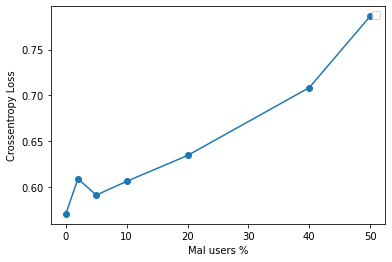

In [13]:
plt.plot(mal_users_percentages, losses, marker='o')


plt.xlabel("Mal users %")
plt.ylabel("Crossentropy Loss")
plt.show()

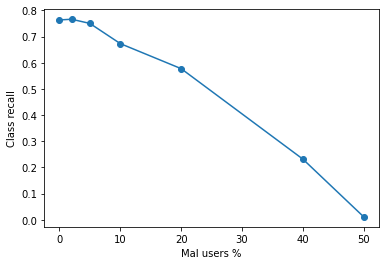

In [24]:
plt.plot(mal_users_percentages, class_recall, marker='o')


plt.xlabel("Mal users %")
plt.ylabel("Class recall")
plt.show()

### Plot #2, graphs for x: n clients, y: metrics

Another interesting set of experiments is the behaviour of the model and the success of the attack while the total number of users used for training increases and decreases. More users in the training procedure lead to more accurate results, as the model is fed with more data while learning, something that logically results into better accuracy of the overall model. Moreover, as an intuition it is realistic to assume that a limited number of users lead in an easier manipulation of the training process by an adversary. However, it is intriguing to observe how the presence of malicious users will indeed impact the above-mentioned rule and our intuition.

In [10]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)


# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)


n_clients_list = [20, 50, 100, 150, 200]

for n_clients in n_clients_list:
    # fix the random clients so that they are the same for every model
    clients = []

    eval_acc = []
    eval_loss = []
    eval_recall = []

    for i in range(n_train_epochs):
        clients.append(random.sample(emnist_train.client_ids, n_clients))

    for i in mal_users_percentages:
        mal_users_percentage = i / 100
        evaluation_state = evaluation_process.initialize()

        
        emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

        training_process = tff.learning.algorithms.build_unweighted_fed_avg(
            mnist_model,
            client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
            server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

        train_state = training_process.initialize()
        
        print("Model with " + str(i) + "% mal clients")
        for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
            # clients = emnist_train.client_ids[0:n_clients]

            federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=mal_users_percentage)      
            
            # run a next on the training process to train the model
            result = training_process.next(train_state, federated_train_data)
            # update the model's state and get access to the metrics
            train_state = result.state

            # print the training metrics
        
        # evaluate after training
            
        # get weights from the trained model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']


        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])
    
    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)
    

Model with 0% mal clients


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Model with 5% mal clients


100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


Model with 10% mal clients


100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Model with 20% mal clients


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Model with 40% mal clients


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Model with 50% mal clients


100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


Model with 0% mal clients


100%|██████████| 25/25 [01:25<00:00,  3.42s/it]


Model with 5% mal clients


100%|██████████| 25/25 [01:26<00:00,  3.48s/it]


Model with 10% mal clients


100%|██████████| 25/25 [01:26<00:00,  3.46s/it]


Model with 20% mal clients


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


Model with 40% mal clients


100%|██████████| 25/25 [01:30<00:00,  3.60s/it]


Model with 50% mal clients


100%|██████████| 25/25 [01:31<00:00,  3.68s/it]


Model with 0% mal clients


100%|██████████| 25/25 [02:52<00:00,  6.91s/it]


Model with 5% mal clients


100%|██████████| 25/25 [02:55<00:00,  7.03s/it]


Model with 10% mal clients


100%|██████████| 25/25 [02:57<00:00,  7.11s/it]


Model with 20% mal clients


100%|██████████| 25/25 [02:53<00:00,  6.94s/it]


Model with 40% mal clients


100%|██████████| 25/25 [02:59<00:00,  7.20s/it]


Model with 50% mal clients


100%|██████████| 25/25 [03:00<00:00,  7.21s/it]


Model with 0% mal clients


100%|██████████| 25/25 [04:12<00:00, 10.12s/it]


Model with 5% mal clients


100%|██████████| 25/25 [04:16<00:00, 10.25s/it]


Model with 10% mal clients


100%|██████████| 25/25 [04:15<00:00, 10.21s/it]


Model with 20% mal clients


100%|██████████| 25/25 [04:18<00:00, 10.35s/it]


Model with 40% mal clients


100%|██████████| 25/25 [04:26<00:00, 10.65s/it]


Model with 50% mal clients


100%|██████████| 25/25 [04:30<00:00, 10.83s/it]


Model with 0% mal clients


100%|██████████| 25/25 [05:45<00:00, 13.81s/it]


Model with 5% mal clients


100%|██████████| 25/25 [05:39<00:00, 13.58s/it]


Model with 10% mal clients


100%|██████████| 25/25 [05:39<00:00, 13.56s/it]


Model with 20% mal clients


100%|██████████| 25/25 [05:44<00:00, 13.77s/it]


Model with 40% mal clients


100%|██████████| 25/25 [05:51<00:00, 14.06s/it]


Model with 50% mal clients


100%|██████████| 25/25 [05:57<00:00, 14.29s/it]


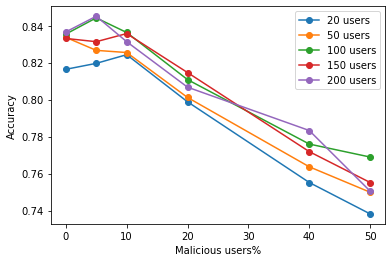

In [19]:
for cnt, model_acc in enumerate(accs):

    plt.plot(mal_users_percentages, model_acc, label=str(n_clients_list[cnt]) + " users", marker='o')

plt.xlabel("Malicious users%")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

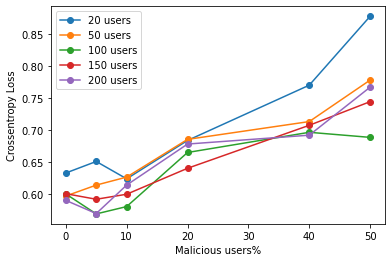

In [20]:
for cnt, model_loss in enumerate(losses):
    
    plt.plot(mal_users_percentages, model_loss, label=str(n_clients_list[cnt]) + " users", marker='o')
    
plt.xlabel("Malicious users%")
plt.ylabel("Crossentropy Loss")

plt.legend()
plt.show()

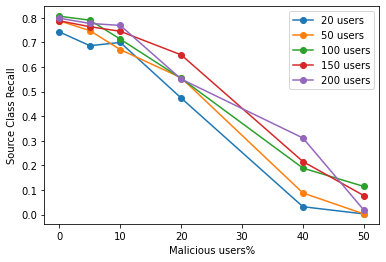

In [21]:
for cnt, model_recall in enumerate(class_recall):
    
    plt.plot(mal_users_percentages, model_recall, label=str(n_clients_list[cnt]) + " users", marker='o')

plt.xlabel("Malicious users%")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

By observing the above figures (TBD), we can point out that the number of users used for training can impact all of our models: the hones one along with the poisoned ones. The drop in the model's accuracy when a small number of users are taking part in the training procedure can be observed even from the honest model, giving us the understanding that limited users cause a drop in the model's accuracy, due to limited data given as input during the learning stage. 

However, there is not a significant derivation from the standard measurements of the metrics of the models, even when limited users are present. In the honest model, even with 20 users, we have an accuracy higher than 82%, and less than 0.5% difference than when 500 users are used. This is an indication that the model, and the FL setting in general, perform well even with limited training data after a sufficient number of epochs. 

When it comes to poisoning, once again we do not observe any significant derivation when limited number of users are utilized, as for the most extreme setting (20 users, 10 of whom are compromised) we observe that the model performs similarly to the ones with the same malicious users percentage but higher participation in the training procedure.

To conclude this set of experiments, we can safely say that the adversary does not gain any significant advantage when limited number of users are used in the training process, given the fact that they control a subset of them.

### Plot 4: Poisoning only on the first and last half of the epochs

The final set of experiments that we are going to conduct with a goal of testing the success of a poisoning attack in FL systems, is inspired by (TODO cite). In this piece of literature, authors explain and prove the fact that poisoning that happens on the first rounds of training does not have a significant impact on the attack's success if it stops after a certain point in the learning process. 

To practically prove this statement, we are going to launch the attack for the first half of the epochs only, and then for the last half. We are going to compare results based on our known metrics that are proven to showcase the effect of the attacks. The percentage of the attackers present in the training process is going to be fixed and set to 40%, a number that is proven to have significant effect to the model's and source class' accuracy, without compromising the model entirely. We are going to compare those results by also plotting the metrics of a totally honest model, throughout the training process.

#### Poisoning in the first half of epochs

In [44]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)


# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

percentages = [0, 40]
for mal_users_percentage in percentages:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    # mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(mal_users_percentage) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]
        if epoch < n_train_epochs / 2:        
            federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=(mal_users_percentage / 100))      
        else:
            federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=0)   
            
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        # print the training metrics
        
        # get weights from the trained model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)


Model with 0% mal clients


100%|██████████| 30/30 [04:24<00:00,  8.83s/it]


Model with 40% mal clients


100%|██████████| 30/30 [04:28<00:00,  8.94s/it]


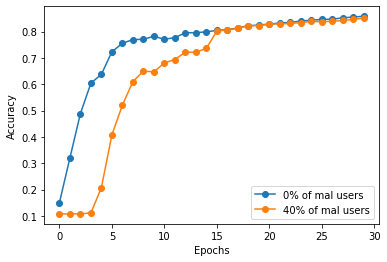

In [45]:
epochs = [x for x in range(0, n_train_epochs)]

for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label=str(percentages[cnt]) + "% of mal users", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

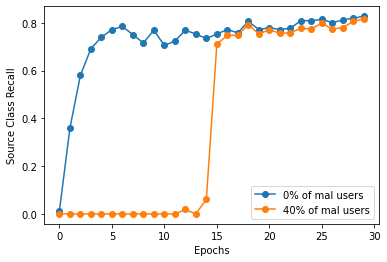

In [46]:
epochs = [x for x in range(0, n_train_epochs)]

for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(percentages[cnt]) + "% of mal users", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

In the graphs presented in the above Figures (TBD), we can clearly observe that during the first 15 epochs that 40% of the participants act maliciously, both the accuracy and the recall have a significant decrease in comparison with the totally honest model. However, after the point that the model stops being poisoned during the learning process, we can see that the metrics quickly rise into normal levels, and after 15 epochs without poisoning, the model behaves and predicts the evaluation set almost as good as the honest one. During the experiments we found remarkable the speed of the model restoring back to normal behaviour, as we can see that in the immediate epoch after the poisoning stops, it gains almost 70% in the recall metric. Thus, the intuition that we had along with the observation from (TODO cite) was indeed correct: attacking the model in the first half of the epochs is not enough for poisoning attacks to effectively alter the predictions of the model after its complete training.

### Poisoning the last half of the epochs

In [47]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)


# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

percentages = [0, 40]
for mal_users_percentage in percentages:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    # mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(mal_users_percentage) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]
        if epoch > n_train_epochs / 2:        
            federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=(mal_users_percentage / 100))      
        else:
            federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=0)   
            
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        # print the training metrics
        
        # get weights from the trained model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)


Model with 0% mal clients


100%|██████████| 30/30 [04:21<00:00,  8.71s/it]


Model with 40% mal clients


100%|██████████| 30/30 [04:28<00:00,  8.95s/it]


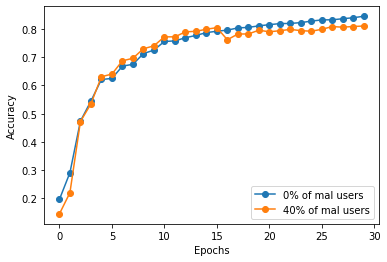

In [48]:
epochs = [x for x in range(0, n_train_epochs)]

for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label=str(percentages[cnt]) + "% of mal users", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

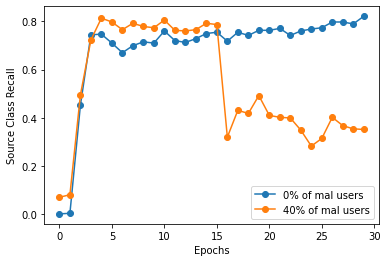

In [49]:
epochs = [x for x in range(0, n_train_epochs)]

for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(percentages[cnt]) + "% of mal users", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

The final plots, as shown in Figures (TBD) display a successful poisoning attack, even when the model is only poisoned during the last half of th epochs. We can observe that the effect is not equal to the one that the experiments that attacked during the whole training process have (recall metric was close to 0 after 30 epochs of poisoning), but nevertheless the attack is highly visible, as the recall metric in this experiment fails to surpass the 50% mark. If we combine it with the drop in the accuracy that we observe, we can safely say that poisoning only the last half of the epochs has a significant effect to the model. 

Thus, by concluding this set of experiments we have to point out that the timing of poisoning is significant when launching such an attack, as its success is higher when poisoning the dataset in the last training rounds, rather than the first ones.